In [ ]:
"""

# ML Project - CGAN Reimplementation

# Baseline ML Mastery CGAN by Jason Brownlee - FMNIST
# Applied to CIFAR-100
# Evaluated using FID Metric for Image Similarity

"""

##
import numpy as np
import keras
from keras.datasets.cifar10 import load_data
from keras.models import Model
from keras.utils import plot_model
from keras import models
from keras import layers
import matplotlib as mpl


from matplotlib import pyplot as plt


###

# Load the CIFAR10 Dataset and Plot some Examples

(x_train, y_train), (x_test, y_test) = load_data()

# Plot an Image from Each Class

plt.figure(figsize=(16,16))
unique_labels = np.unique(y_train)
print(unique_labels)

for ii in unique_labels:
    plt.subplot(4, 5, 1 + ii)
    first_instance_class_index = np.where(y_train == ii)
    plt.imshow(x_train[first_instance_class_index[0][0]])
    plt.title(str(ii))
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('CIFAR10.png')


plt.tight_layout()
plt.show()


## Data Loading and Simple Preprocessing Functions
def load_CIFAR_Data():
    # load dataset
    (x_train, y_train), (_, _) = load_data()  # CIFAR10

    x_train_processed = x_train.astype('float32')

    # Preprocess Pixel intensity to occupy values that support tanh function

    x_train_processed = (x_train_processed - 127.5) / 127.5  # Generator uses tanh activation so rescale

    # Since the Generator Images occupy space from -1 to 1 the Training Data should do the same

    return [x_train_processed, y_train]

## Define the Discriminator for the GAN

def build_discriminator(input_image=(32,32,3)):

	# Build the Discriminator using Keras Functional API rather than Sequential

	# Define the Inputs to the Discriminator (3 Channel Images 32x32) - 10 Classes
    in_label = keras.layers.Input(shape=(1,))

    # We will Map each Class n_classes to a different 50 element Vector Representation that will be learned by the Discriminator
    layer_stack = keras.layers.Embedding(20, 50)(in_label)  # Embed 100 Class Representation into Vector of 50

	# Scale up to the Image Size
    layer_stack = keras.layers.Dense(input_image[0] * input_image[1])(layer_stack)  # Learn Representation Image as Flattened Vector

	# Reshape to Image Size
    layer_stack = keras.layers.Reshape((input_image[0], input_image[1], 1))(layer_stack)  # 32x32x1

    input_image = keras.Input(shape=input_image)

    # Image Input Size
    concatenated_input = keras.layers.Concatenate()([input_image , layer_stack])  # Stacked 32x32x3 (Image) + 32x32x1 (Embedded Representation of Label)

    # Similar to Traditional GAN (CNN) - Downsample Images
    model_f = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(concatenated_input)  # 16x16x128
    model_f = keras.layers.LeakyReLU(alpha=0.2)(model_f)

    # Downsample Images
    model_f = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(model_f)  # 8x8x128
    model_f = keras.layers.LeakyReLU(alpha=0.2)(model_f)

    # Apply Flattening Layer
    model_f = keras.layers.Flatten()(model_f)  # 8192  (8*8*128=8192)

    # Apply Dropout Layer
    model_f = keras.layers.Dropout(0.4)(model_f)

    # Output of Generator
    out_layer = keras.layers.Dense(1, activation='sigmoid')(model_f) # Needs to be Binary -> Determine if Image is Real or Not

    # Define the Full Discriminator Model
    model = keras.Model([input_image, in_label], out_layer) # Inputs are concatenated image and label -> Out_Layer is the Entire Architecture

    # Compile with Adam Optimizer
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

discriminator_model = build_discriminator()
print(discriminator_model.summary())
# plot_model(discriminator_model, to_file='discriminator_model.png')

## Define the Generator for the GAN, should receive Latent Dimension and Input Label

def build_generator(latent_dim):

    in_label = keras.layers.Input(shape=(1,)) # Similar to Discriminator

	# Each Label will be represented as a vector of 50
    layer_stack = keras.layers.Embedding(20, 50)(in_label)  # Shape 100,50

    # Linear Multiplication - > Since Input images are 32x32 and they are Downsampled Twice -> Need 8x8
    layer_stack = keras.layers.Dense(64)(layer_stack)  # 1,64

    # Reshape
    layer_stack = keras.layers.Reshape((8, 8, 1))(layer_stack)

    # Create Generator Input Layer
    in_layer = keras.layers.Input(shape=(latent_dim,))  # Input Vector with Dimension 100

    # Now we will Create the 8x8 Image and Upscale to 32x32 for Output
    # foundation for 8x8 image

    image_dim = [8,8]

    model_gn = keras.layers.Dense(128 * image_dim[0] * image_dim[1])(in_layer)  # Will be a 128 x 8 x 8 Dense Layer
    model_gn = keras.layers.LeakyReLU(alpha=0.2)(model_gn)
    model_gn = keras.layers.Reshape((8, 8, 128))(model_gn)  # Rehape to 8 x 8 x 128

    concatenated_input = keras.layers.Concatenate()([model_gn, layer_stack])  # Shape=8x8x129 ( Will Input includes the Labels for Conditioning )

    # Upsample Images 16x16
    gn = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(concatenated_input)  # 16x16x128
    gn = keras.layers.LeakyReLU(alpha=0.2)(gn)

    # Upsample Images 16x16
    gn = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gn)  # 32x32x128
    gn = keras.layers.LeakyReLU(alpha=0.2)(gn)

    # Output Layer
    out_layer = keras.layers.Conv2D(3, (8, 8), activation='tanh', padding='same')(gn)  # 32x32x3

    model = keras.Model([in_layer, in_label], out_layer)

    # We do not compile the model as it isn't trained like we train the discriminator.

    return model

latent_dim = 100

generator_model = build_generator(latent_dim)
print(generator_model.summary())
# plot_model(generator_model, to_file='generator_model.png')

##

# Define the GAN by combining the Generator and Discriminator, We will hold the Discriminator Constant while
# Generator is being trained.

def build_CGAN(generator_model, discriminator_model):
    discriminator_model.trainable = False  # Discriminator is trained separately. So set to not trainable.

    # Get Size Constraints of Generator
    generator_noise, generator_label = generator_model.input  # Latent Vector + Label Size

    # Get Image Output Size Constraints Generator
    generator_output = generator_model.output

    # generator image output and corresponding input label are inputs to discriminator

    # Generated Image and Input Label are input to Discriminator
    CGAN_Output = discriminator_model([generator_output, generator_label])

    # Send Latent Noise Vector plus Label as Inputs
    model = keras.Model([generator_noise, generator_label], CGAN_Output)
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

CGAN_model = build_CGAN(generator_model,discriminator_model)
print(CGAN_model.summary())
# plot_model(CGAN_model, to_file='CGAN_Model.png')


## Need a function to Generate Random Latent Vector Points for the Generator

def generate_generator_inputs(latent_dim, n_samples):

    # Generate Random Latent Points for N-Samples
    latent_points = np.random.randn(latent_dim * n_samples)

    # Reshape for Network
    generator_input = latent_points.reshape(n_samples, latent_dim)

    # Generate Random Labels for the Inputs up to the True Number of Classes in Dataset
    labels = np.random.randint(0, 20, n_samples)

    return [generator_input, labels]

## Need a function to Sample Real Dataset - Assign Label of 1 to all these Samples indicating
# they are real images.

def sample_real_dataset(dataset, n_samples):

    # Split TF Dataset into Images + Labels
    images, labels = dataset

    # Select N Random Samples
    random_index = np.random.randint(0, images.shape[0], n_samples)

    # X_Samples
    X_Samples, Sampled_Labels = images[random_index], labels[random_index]

    # Labels for Binary (Real, Non-Real) Classifier  == 1 (REAL)
    Y = np.ones((n_samples, 1))  # Label=1 indicating they are real

    return [X_Samples, Sampled_Labels], Y

## Function to Generate Random Examples with Labels

def generate_fake_samples(generator, latent_dim, n_samples):

    # Generate Latent Sample Points for N Samples
    generator_input, labels = generate_generator_inputs(latent_dim, n_samples)

    # Predict Outputs of the Trained Generator
    images = generator.predict([generator_input, labels])

    # Automatically Label Generated Samples as Fake
    Y = np.zeros((n_samples, 1))  # Label=0 indicating they are fake

    return [images, labels], Y

# Steps to Train CGAN
# 1.) Select Random Images/Labels from Real Dataset
# 2.) Generate Set of Images/Labels from Generator
# 3.) Feed both sets into Discriminator
# 4.) Set Loss for Real and Fake and Combined Loss

g_losses = []
d_losses = []


def train(generator_model, discriminator_model, CGAN_Model, real_dataset, latent_dim, n_batch=128):

    # Compute the Number of Batches per Epoch by [Size Dataset / Size Batch]
    n_batches_in_epoch = int(dataset[0].shape[0] / n_batch)

    # Epoch Loop
    for i in range(200):

        # Create a Dataset of 64 Fake and Real Images
        for j in range(n_batches_in_epoch):

            # Sample from the True Dataset
            [X_Real, Labels_Real], Y_Real = sample_real_dataset(real_dataset, int(n_batch / 2))

            discriminator_real_loss , _ = discriminator_model.train_on_batch([X_Real, Labels_Real], Y_Real)

            # Generate Samples from the Generator
            [X_Fake, Fake_labels], Y_Fake = generate_fake_samples(generator_model, latent_dim, int(n_batch / 2))

            # Train Discriminator on Fake Data
            discriminator_fake_loss, _ = discriminator_model.train_on_batch([X_Fake, Fake_labels], Y_Fake)

            d_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss) #Average loss if you want to report single..

            # Prepare Latent Point Vectors for Generator
            [generator_input, labels] = generate_generator_inputs(latent_dim, n_batch)

            # The Generator wants the Discriminator to Labels images as 1 or REAL
            Y_GAN = np.ones((n_batch, 1))

            g_loss = CGAN_Model.train_on_batch([generator_input, labels], Y_GAN)

        g_losses.append(g_loss)

    # Save the Generator Model
    generator_model.save('cifar10_conditional_generator_200_epochs.h5')
    generator_model.save('./drive/MyDrive/ML_Project/cifar10_conditional_generator_200_epochs.h5')


## Train the CGAN
# Initialize the Latent Size Dimension
latent_dim = 100
# Build the Discriminator using Keras Functional API
discriminator_model = build_discriminator()
# Build the Generator using Keras Functional API
generator_model = build_generator(latent_dim)
# Combine both Models into CGAN
CGAN_Model = build_CGAN(generator_model, discriminator_model)

# Load the Real CIFAR100 Dataset
dataset = load_CIFAR_Data()
# train model
train(generator_model, discriminator_model, CGAN_Model, dataset, latent_dim)



(100, 100)
(100,)
4/4 [==============================] - 0s 7ms/step


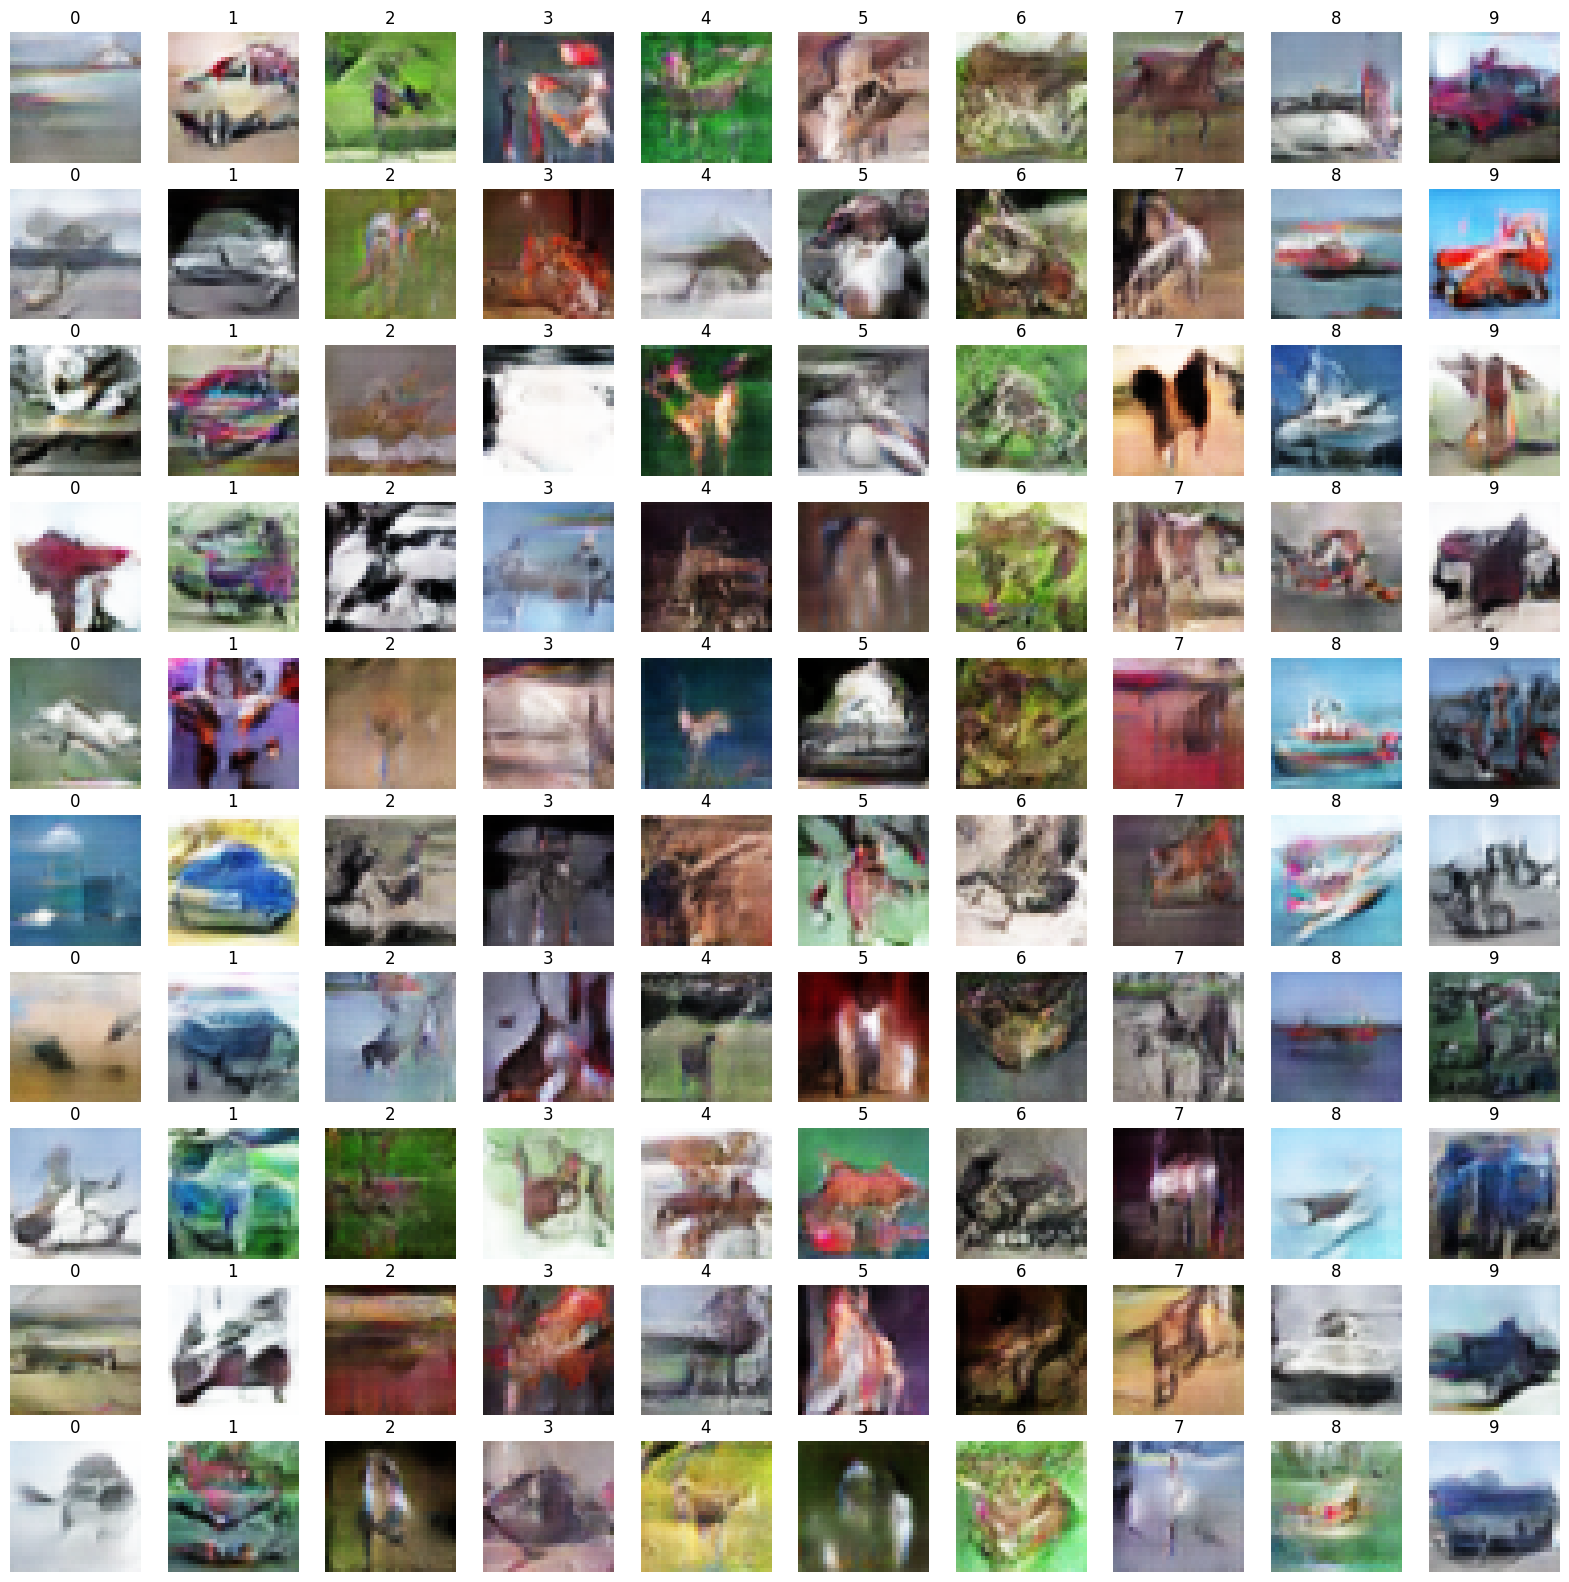

NameError: ignored

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
import tensorflow as tf

model = tf.keras.saving.load_model('./cifar10_conditional_generator_200_epochs.h5')

# generate multiple images

latent_points, labels = generate_generator_inputs(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images

print(latent_points.shape)
print(labels.shape)
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 

plt.figure(figsize=(20,20))
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
		plt.title(labels[i])
	
	
	plt.show()
    
show_plot(X, 10)
plt.savefig('Samples_with_Conditioning_200_Epochs.png')

## Plot the Discriminator and Generator Losses
plt.figure(figsize=(12,8))
plt.plot(g_losses,label='Generator Loss')
plt.plot(d_losses,label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Discriminator vs. Generator Loss for CIFAR10 Training')
plt.legend()
plt.show()
plt.savefig('Losses_Plot_200_Epochs.png')



In [ ]:
from skimage.transform import resize
import scipy

## Evaluate all the models and generated pictures vs. each Label using the Frechet Inception Distance (adapted from MLMastery)

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

g_model = tf.keras.saving.load_model('./cifar10_conditional_generator_200_epochs.h5')

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3)) # We will have to Resize Images so they may be evaluated by InceptionV3

(x_train, y_train), (x_test, y_test) = load_data() # Load the CIFAR10 Data

# For the purpose of CGAN just checking FID is not enough, we want to do an evaluation per class to see how well the network was conditioned for labels. We will compare to the images in the training set.

unique_labels = np.unique(y_train)


# FID Calculator
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# Image array scaling function
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)


FID_SCORES = np.zeros((3,len(unique_labels)))

for jj in range(3):

    if jj == 0:
      g_model = tf.keras.saving.load_model('./cifar10_conditional_generator_mode_collapse.h5')
      print('cGAN MODE COLLAPSE FID SCORES:')
    if jj == 1:
      g_model = tf.keras.saving.load_model('./cifar10_conditional_generator_75_epochs.h5')
      print('cGAN 75 EPOCH TUNED FID SCORES:')
    if jj == 2:
      g_model = tf.keras.saving.load_model('./cifar10_conditional_generator_200_epochs.h5')
      print('cGAN 200 EPOCH TUNED FID SCORES:')

    for ii in unique_labels:
        match_class_index = np.where(y_train == ii)
        this_class_images = x_train[match_class_index[0]]
        np.random.shuffle(this_class_images)
        this_class_images = this_class_images[:500] # Only Compare 500 Real and 500 Fake
        print(this_class_images.shape)

        # Generate Fake Samples from same Class
        latent_points, labels = generate_generator_inputs(100, len(this_class_images))
        # Specify Labels
        labels = np.ones(len(this_class_images)) * ii
        # Generate Images
        X  = g_model.predict([latent_points, labels])
        # Scale Images to [0,1]
        X = (X + 1) / 2.0
        X = (X*255).astype(np.uint8)
        # Convert to Floating Point
        images_real = this_class_images.astype('float32')
        images_fake = X.astype('float32')

        print(X.shape)
        # Resize Images
        images_real = scale_images(images_real,(299,299,3))
        images_fake = scale_images(images_fake,(299,299,3))

        images_real = preprocess_input(images_real)  
        images_fake = preprocess_input(images_fake)

        # calculate fid
        fid = calculate_fid(model, images_real, images_fake)
        print('CLASS ' + str(ii))
        print('FID: %.3f' % fid)
        FID_SCORES[jj][ii] = fid


print(FID_SCORES)


cGAN MODE COLLAPSE FID SCORES:
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 103ms/step
CLASS 0
FID: 336.402
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 1
FID: 346.599
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 2
FID: 295.096
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 103ms/step
CLASS 3
FID: 315.103
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 4
FID: 272.295
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 5
FID:

cGAN 75 EPOCH TUNED FID SCORES:
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 0
FID: 144.552
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 1
FID: 164.511
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 2
FID: 154.471
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 3
FID: 139.001
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 104ms/step
CLASS 4
FID: 117.340
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 5
FID

cGAN 200 EPOCH TUNED FID SCORES:
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 0
FID: 135.885
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 1
FID: 145.301
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 2
FID: 141.674
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 3
FID: 128.871
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 4
FID: 112.269
(500, 32, 32, 3)
16/16 [==============================] - 0s 7ms/step
(500, 32, 32, 3)
16/16 [==============================] - 2s 105ms/step
CLASS 5
FI